# Vehicle Detection workbook

## Imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog

%matplotlib inline

## Training the classifier

In [2]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [3]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [4]:
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
        print('Nr of spatial features: ', len(spatial_features))
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
        print('Nr of histogram features: ', len(hist_features))
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))   
            hog_features = np.ravel(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        print('Nr of hog features: ', len(np.ravel(hog_features)))
    print('Nr of features together: ', len(np.concatenate(img_features)))
    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

In [7]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32, 
                         orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, 
                         spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Creat a list to append features vectors later on
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        
        # Read image by image
        img = mpimg.imread(file)
        
        # Apply color conversion if other colorspace than RGB
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)   
        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
            
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
            
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True)
            file_features.append(hog_features)
        
        # Concatenate all the features extracted and append to features list
        
        
        features.append(np.concatenate(file_features))
    return features

In [8]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap = 'hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

## Visualizing HOG features

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32
Nr of hog features:  1764
Nr of features together:  1764
Nr of hog features:  1764
Nr of features together:  1764
1764


C:\Users\Martin\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


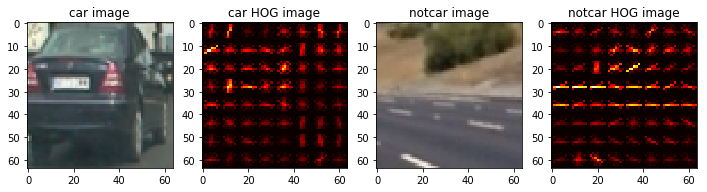

In [9]:
images = glob.glob('./dataset/large/*/*/*.png')
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])



color_space = 'LUV'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 2 #'ALL'
spatial_size = (16,16)
hist_bins = 16
spatial_feat = False # 768 features
hist_feat = False # 48 features
hog_feat = True # 1176 features

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

print(len(car_features))

images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize (fig, 1, 4, images, titles)

# Training the classifier

In [ ]:
color_space = 'LUV' # RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (16,16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True


images = glob.glob('./dataset/large/*/*/*.png')
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
        
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])


t = time.time()

n_samples = 1000

random_ids = np.random.randint(0,len(cars), n_samples)

cars_test =  cars #np.array(cars)[random_ids] # 
notcars_test = notcars #np.array(notcars)[random_ids]  #

#print(cars_test)
#print(notcars_test)

#img = mpimg.imread(cars_test[0])

car_features = extract_features(cars_test, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars_test, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

#print('Car feature length: ', len(car_features), ' shape: ', np.array(car_features).shape)
#print('Not car feature length: ', len(notcar_features), ' shape: ', np.array(notcar_features).shape)

print(round(time.time() - t, 2), ' seconds to compute features')

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

print('Feature vector length: ', len(X[0]))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train) # ToDo: Should I find scaler for whole data or just for training data
# Apply the scaler to both X_train and X_test
scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

print('Using: ', orient, ' orientations, ', pix_per_cell, ' picels per cell, ', cell_per_block, ' cells per block, ',
     hist_bins, ' histogram bins and ', spatial_size, ' spatial sampling')



# Use a linear SVC (support vector classifier)
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()

# Train the SVC
svc.fit(scaled_X_train, y_train) # ToDo: Use a better optimizer/hyperparameter selector

t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

print('Test Accuracy of SVC = ',round(svc.score(scaled_X_test, y_test),3))

print('Saving off training features...')

dist_pickle = {}

dist_pickle["color_space"] = color_space
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["hog_channel"] = hog_channel
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins

dist_pickle["spatial_feat"] = spatial_feat
dist_pickle["hist_feat"] = hist_feat
dist_pickle["hog_feat"] = hog_feat

dist_pickle["svc"] = svc
dist_pickle["X_scaler"] = X_scaler

pickle.dump(dist_pickle, open("./svc.p", "wb"))

print('Saved')

# Hog subsampling and looking for cars in images

In [10]:
def convert_color(img, conv='YCrCb'):
    if color_space != 'RGB':
        if conv == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        if conv == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        if conv == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        if conv == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        if conv == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

In [11]:
def find_cars(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    #Create empty heat map
    heat_map = np.zeros_like(img[:,:,0])
    on_windows = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = cells_per_step  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                heat_map[ytop_draw + ystart:ytop_draw + win_draw + ystart, xbox_left:xbox_left + win_draw] += 1
                startx = xbox_left
                endx = xbox_left+win_draw
                starty = ytop_draw+ystart
                endy = ytop_draw+win_draw+ystart
                window_hit = ((startx, starty), (endx, endy))
                on_windows.append(window_hit)
    return draw_img, heat_map, on_windows

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

C:\Users\Martin\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


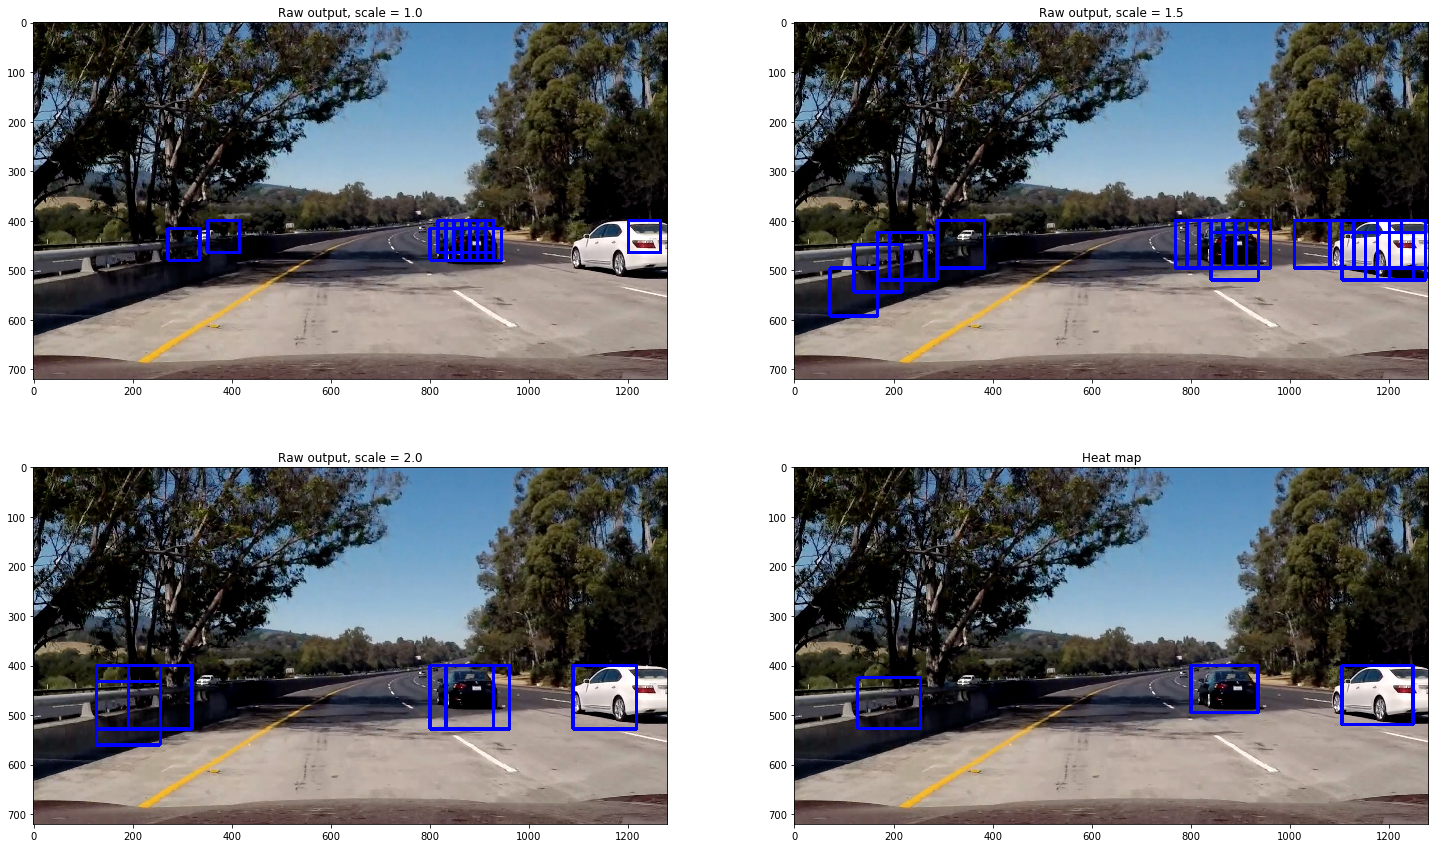

In [13]:
# load a pe-trained svc model with training parameters from a serialized (pickle) file
dist_pickle = pickle.load(open("./svc.p", "rb"))

color_space = dist_pickle["color_space"]
orient = dist_pickle["orient"] 
pix_per_cell = dist_pickle["pix_per_cell"] 
cell_per_block = dist_pickle["cell_per_block"] 
hog_channel = dist_pickle["hog_channel"]
spatial_size = dist_pickle["spatial_size"] 
hist_bins = dist_pickle["hist_bins"] 

spatial_feat = dist_pickle["spatial_feat"] 
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]

svc = dist_pickle["svc"] 
X_scaler = dist_pickle["X_scaler"]

# Do the other stuff

img = mpimg.imread('./test_images/test5.jpg')
  
ystart = 400
ystop = 656

cells_per_step = 2
scale = 1.0   
out_img_1, heat_map_1, on_window_1 = find_cars(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

scale = 1.5
out_img_2, heat_map_2, on_window_2 = find_cars(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

scale = 2.0
out_img_3, heat_map_3, on_window_3 = find_cars(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


heat_map = np.zeros_like(img[:,:,0])
heat_map = add_heat(heat_map, on_window_1)
heat_map = add_heat(heat_map, on_window_2)
heat_map = add_heat(heat_map, on_window_3)

heat_map = apply_threshold(heat_map,3)
labels = label(heat_map)

draw_img = draw_labeled_bboxes(np.copy(img), labels)

#plt.imshow(out_img_3)

images = [out_img_1, out_img_2, out_img_3, draw_img]
titles = ['Raw output, scale = 1.0', 'Raw output, scale = 1.5', 'Raw output, scale = 2.0', 'Heat map']
fig = plt.figure(figsize=(25,15))
visualize (fig, 2, 2, images, titles)

In [14]:
def process_image(img):
    ystart = 400
    ystop = 656
    
    cells_per_step = 2
    scale = 1.0    
    
    out_img_1, heat_map_1, on_window_1 = find_cars(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 1.5

    out_img_2, heat_map_2, on_window_2 = find_cars(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 2

    out_img_3, heat_map_3, on_window_3 = find_cars(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


    heat_map = np.zeros_like(img[:,:,0])
    heat_map = add_heat(heat_map, on_window_1)
    heat_map = add_heat(heat_map, on_window_2)
    heat_map = add_heat(heat_map, on_window_3)

    #heat_map = np.concatenate(heat_map_1, heat_map_2)

    heat_map = apply_threshold(heat_map,0)
    labels = label(heat_map)

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [15]:
class Detections():
    def __init__(self):
        self.recent_findings = []
        self.smooth_factor = 30 # last 10 frames, as we take 3 different scales per frame
      
    def process_image(self, img):
        ystart = 400
        ystop = 656
        
        cells_per_step = 2
        scale = 1.0    

        out_img_1, heat_map_1, on_window_1 = find_cars(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

        scale = 1.5

        out_img_2, heat_map_2, on_window_2 = find_cars(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

        scale = 2

        out_img_3, heat_map_3, on_window_3 = find_cars(img, ystart, ystop, scale, cells_per_step, svc, X_scaler, color_space, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

        self.recent_findings.append(on_window_1)
        self.recent_findings.append(on_window_2)
        self.recent_findings.append(on_window_3)

        heat_map = np.zeros_like(img[:,:,0])
        
        for frame in self.recent_findings[-self.smooth_factor:]:
            
            #heat_map = add_heat(heat_map, on_window_1)
            heat_map = add_heat(heat_map, frame)

        #heat_map = np.concatenate(heat_map_1, heat_map_2)

        heat_map = apply_threshold(heat_map,20)
        labels = label(heat_map)

        draw_img = draw_labeled_bboxes(np.copy(img), labels)

        return draw_img

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

start_second = 35
end_second = 45

# Output file name
output_video = './project_video_output.mp4'

# Input file name
input_video = VideoFileClip("./project_video.mp4")#.subclip(start_second,end_second)
#input_video = VideoFileClip("./test_video.mp4")#.subclip(start_second,end_second)

detections = Detections()

# Processing
output_video_clip = input_video.fl_image(detections.process_image) #NOTE: this function expects color images!!
output_video_clip.write_videofile(output_video, audio=False)